In [16]:
# !pip3 install torch
# !pip install scikit-learn

In [17]:
import pandas as pd

In [18]:
# get data
data = pd.read_csv("../usa/processed-usa-data.csv", delimiter=",", names=["Temperature_Bin", "Wind_Speed_Bin", "Amount_of_Accidents"], skiprows=1)
data = data.dropna()

data

,Temperature_Bin,Wind_Speed_Bin,Amount_of_Accidents
0,Extremely Cold,No Wind,5175
1,Extremely Cold,Very Low,22582
2,Extremely Cold,Low,15178
3,Extremely Cold,Slightly Low,7546
4,Extremely Cold,Moderate Low,3503
...,...,...,...
95,Extremely Hot,Moderate High,99
96,Extremely Hot,Slightly High,19
97,Extremely Hot,High,3
98,Extremely Hot,Very High,0


In [19]:
# preprocess data
from sklearn.model_selection import train_test_split

accidents = data["Amount_of_Accidents"].values
average_accidents_per_month = accidents.sum() / (len(accidents) * 48)

print("average accidents per month: ", average_accidents_per_month)

# Perform one-hot encoding on the categorical columns
temperature_encoded = pd.get_dummies(data["Temperature_Bin"], prefix="temperature")
wind_speed_encoded = pd.get_dummies(data["Wind_Speed_Bin"], prefix="wind_speed")

# Combine the encoded features with the amount of accidents
processed_data = pd.concat([temperature_encoded, wind_speed_encoded, data["Amount_of_Accidents"]], axis=1)

# Convert the processed data to PyTorch tensors
X = processed_data.iloc[:, :-1].values
y = processed_data.iloc[:, -1].values

X_train, x_val, y_train,  y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train.shape

average accidents per month:  421.675


(80, 20)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import load
# Evaluate model
model = load("../models/usa-model.pt")

y_pred = model.predict(x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = model.score(x_val, y_val)

# Cross-validation
# cv_scores = cross_val_score(model, X, y, cv=5)  # Perform 5-fold cross-validation

# Print results
print("Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}", "lower is better")
print(f"Mean Absolute Error (MAE): {mae:.2f}", "lower is better")
print(f"R-squared Score (R2): {r2:.2f}", "higher is better")
# print("Cross-Validation Scores:", "higher is better")
# print(cv_scores)

Evaluation Metrics:
Mean Squared Error (MSE): 2014622760.84 lower is better
Mean Absolute Error (MAE): 19162.76 lower is better
R-squared Score (R2): -0.22 higher is better


/home/haukur/miniconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/haukur/miniconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import numpy as np

# lr = LinearRegression()
# lr.fit(X_train, np.log(y_train + 1e-5))

# rf = RandomForestRegressor()

# rf.fit(X_train, np.log(y_train + 1e-5))

# mlp = MLPRegressor(hidden_layer_sizes=(8, 8,8,8, 8, 8,), max_iter=500, activation="relu", solver="adam", learning_rate_init=1e-3, learning_rate="adaptive", random_state=42)
# mlp.fit(X_train, np.log(y_train + 1e-5))

# lr.score(x_val, np.log(y_val + 1e-5)),rf.score(x_val, np.log(y_val + 1e-5)), mlp.score(x_val, np.log(y_val + 1e-5))

from joblib import load

rf = load("../models/usa-model.pt")

# import joblib
# Save model with a higher protocol version
# joblib.dump(rf, "usa-model.pt", protocol=4)


/home/haukur/miniconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/haukur/miniconda3/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
# import joblib

# joblib.dump(rf, "new-usa-model.pt", protocol=4)

[[  5175  22582  15178   7546   3503   1213    414    146     88     28]
 [ 10728  38569  24186  11877   4713   1642    507    146     57     29]
 [ 19400  62352  34356  15802   6050   1915    565    133     74     72]
 [ 33567 100558  50086  21627   8282   2858    772    257    122     81]
 [ 45003 140630  69535  27068   9394   2987    830    223    163     76]
 [ 46526 162833  85158  32693  10247   3048    797    182    116     47]
 [ 43767 181655 111974  39306  10643   2594    565    173     52     35]
 [ 25962 136080 108061  41564   9824   2018    310     45     24     17]
 [  9247  56383  51595  19331   3536    534     75     29      5      7]
 [  1484   9295   8927   3273    717     99     19      3      0      0]]


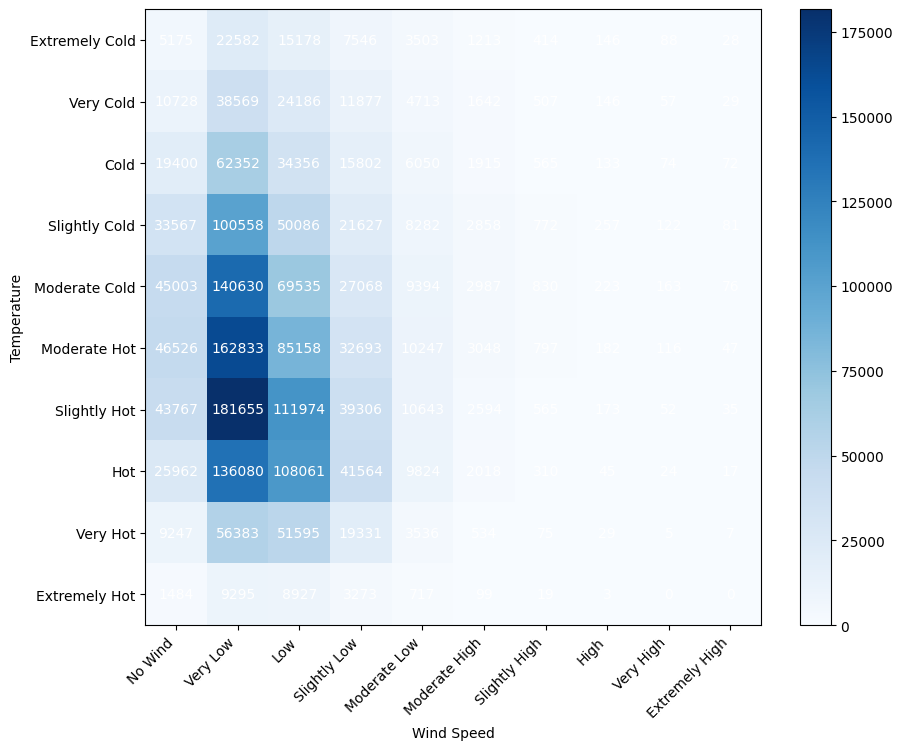

<Figure size 1280x960 with 0 Axes>

In [23]:
import numpy as np
import matplotlib.pyplot as plt

temperature_bins = [
    "Extremely Cold",
    "Very Cold",
    "Cold",
    "Slightly Cold",
    "Moderate Cold",
    "Moderate Hot",
    "Slightly Hot",
    "Hot",
    "Very Hot",
    "Extremely Hot",
]
wind_speed_bins = [
    "No Wind",
    "Very Low",
    "Low",
    "Slightly Low",
    "Moderate Low",
    "Moderate High",
    "Slightly High",
    "High",
    "Very High",
    "Extremely High",
]

graphin_data = data["Amount_of_Accidents"].values.reshape(10, 10)
print(graphin_data)
# Convert the data into a numpy array
confusion_matrix = np.array(graphin_data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set the tick labels and rotation
ax.set_xticks(np.arange(len(wind_speed_bins)))
ax.set_yticks(np.arange(len(temperature_bins)))
ax.set_xticklabels(wind_speed_bins, rotation=45, ha="right")
ax.set_yticklabels(temperature_bins)

# Loop over the data and add text annotations
for i in range(len(temperature_bins)):
    for j in range(len(wind_speed_bins)):
        # the one-hot encodings
        
        
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="w")

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the title and labels
ax.set_xlabel("Wind Speed")
ax.set_ylabel("Temperature")

# Show the plot
plt.figure(dpi=200)
plt.tight_layout()
plt.show()


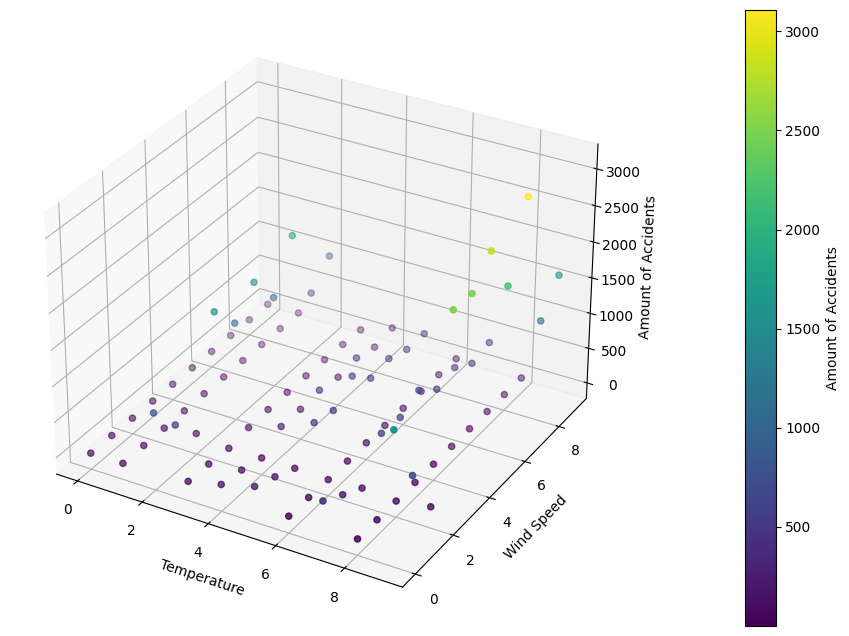

In [24]:
import numpy as np
import matplotlib.pyplot as plt


# Generate meshgrid for temperature and wind speed
temperature_range = np.arange(0, 10)  # Replace with the actual temperature range
wind_speed_range = np.arange(0, 10)  # Replace with the actual wind speed range

# create one-hot encoded features
temperature_one_hot = np.eye(len(temperature_range))[temperature_range]
wind_speed_one_hot = np.eye(len(wind_speed_range))[wind_speed_range]

# Flatten the one-hot encoded features
temperature_flat = temperature_one_hot.reshape(-1, len(temperature_range))
wind_speed_flat = wind_speed_one_hot.reshape(-1, len(wind_speed_range))

# all possible permutations of temperature and wind speed
all_one_hot_encodings = []
for temperature in temperature_flat:
    for wind_speed in wind_speed_flat:
        all_one_hot_encodings.append(np.concatenate([temperature, wind_speed]))

# Convert the list to a numpy array
X_pred = np.array(all_one_hot_encodings)

# Predict the amount of accidents for each combination of temperature and wind speed
y_pred = rf.predict(X_pred)
y_pred = np.exp(y_pred) - 1e-5
# scale down to 1 month
y_pred = y_pred / 48
y_pred


# Create meshgrid for temperature and wind speed
temperature_mesh, wind_speed_mesh = np.meshgrid(temperature_range, wind_speed_range)

# Reshape the meshgrid for plotting
temperature_flat = temperature_mesh.flatten()
wind_speed_flat = wind_speed_mesh.flatten()
y_pred_flat = y_pred.flatten()

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
sc = ax.scatter(temperature_flat, wind_speed_flat, y_pred_flat, c=y_pred_flat, cmap='viridis')

# Set labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('Amount of Accidents')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Amount of Accidents')

# Adjust spacing between the plot and colorbar
plt.subplots_adjust(right=2.5)

plt.show()


/tmp/ipykernel_18145/4089552779.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(temperature_labels, rotation=45, ha='right')
/tmp/ipykernel_18145/4089552779.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wind_speed_labels, rotation=45, ha='right')


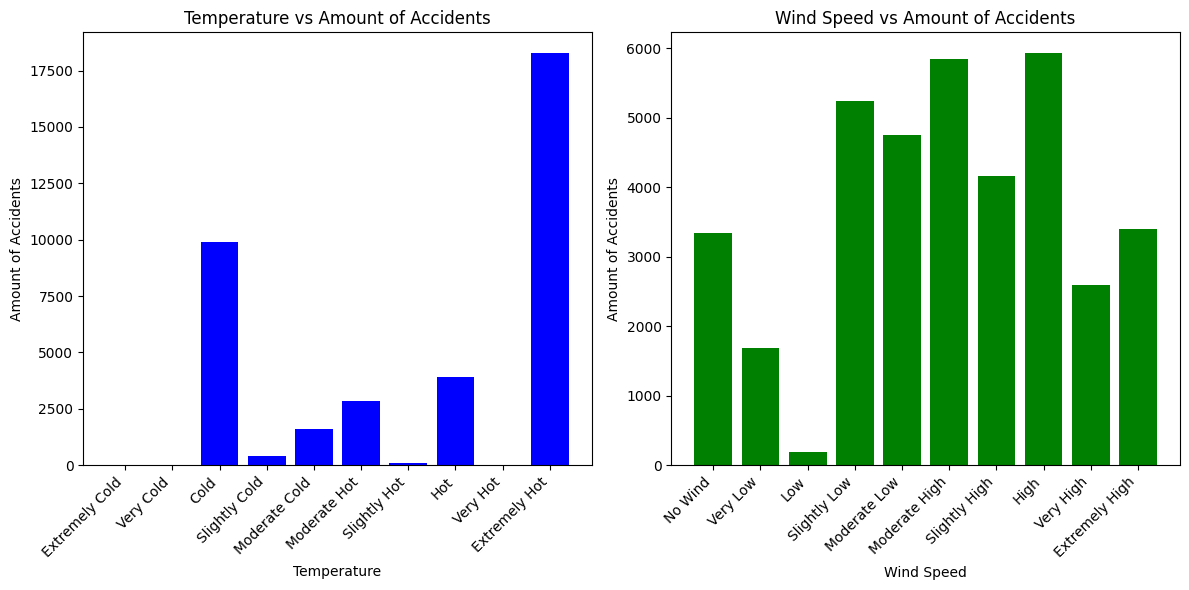

In [25]:
# view each axis separately


# Aggregate the predicted amounts of accidents for each unique temperature and wind speed combination
temperature_unique = np.unique(temperature_flat)
wind_speed_unique = np.unique(wind_speed_flat)
y_pred_aggregated = np.zeros((len(temperature_unique), len(wind_speed_unique)))

for i, temperature in enumerate(temperature_unique):
    for j, wind_speed in enumerate(wind_speed_unique):
        idx = (temperature_flat == temperature) & (wind_speed_flat == wind_speed)
        y_pred_aggregated[i, j] = np.mean(y_pred_flat[idx])


# Assign labels to each bin
temperature_labels = [
    "Extremely Cold",
    "Very Cold",
    "Cold",
    "Slightly Cold",
    "Moderate Cold",
    "Moderate Hot",
    "Slightly Hot",
    "Hot",
    "Very Hot",
    "Extremely Hot",
]
wind_speed_labels = [
    "No Wind",
    "Very Low",
    "Low",
    "Slightly Low",
    "Moderate Low",
    "Moderate High",
    "Slightly High",
    "High",
    "Very High",
    "Extremely High",
]

# Create the bar charts - Temperature vs Amount of Accidents and Wind Speed vs Amount of Accidents
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Temperature vs Amount of Accidents
ax1.bar(temperature_labels, y_pred_aggregated.sum(axis=1), color='blue')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Amount of Accidents')
ax1.set_title('Temperature vs Amount of Accidents')

# Wind Speed vs Amount of Accidents
ax2.bar(wind_speed_labels, y_pred_aggregated.sum(axis=0), color='green')
ax2.set_xlabel('Wind Speed')
ax2.set_ylabel('Amount of Accidents')
ax2.set_title('Wind Speed vs Amount of Accidents')

# Rotate x-axis labels for better visibility
ax1.set_xticklabels(temperature_labels, rotation=45, ha='right')
ax2.set_xticklabels(wind_speed_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

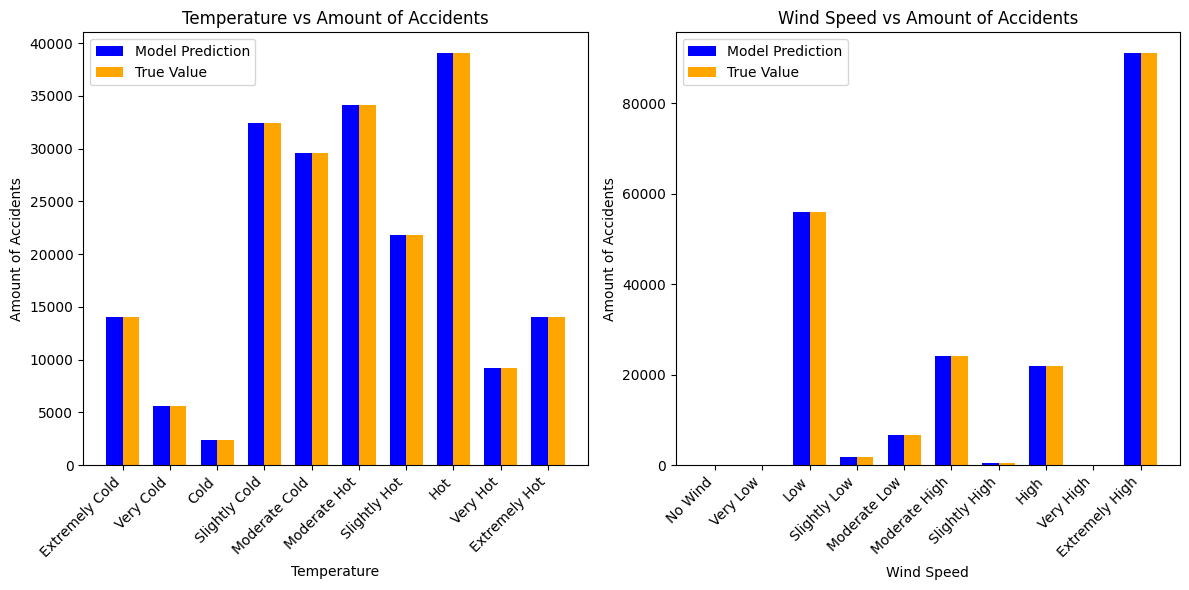

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the processed data
processed_data = pd.read_csv("../usa/processed-usa-data.csv")

# Extract the temperature and wind speed bins, and the amount of accidents
temperature_bins = processed_data["Temperature_Bin"]
wind_speed_bins = processed_data["Wind_Speed_Bin"]
amount_of_accidents = processed_data["Amount_of_Accidents"]

# Aggregate the predicted amounts of accidents for each unique temperature and wind speed combination
temperature_unique = np.unique(temperature_bins)
wind_speed_unique = np.unique(wind_speed_bins)
y_pred_aggregated = np.zeros((len(temperature_unique), len(wind_speed_unique)))

for i, temperature in enumerate(temperature_unique):
    for j, wind_speed in enumerate(wind_speed_unique):
        idx = (temperature_bins == temperature) & (wind_speed_bins == wind_speed)
        y_pred_aggregated[i, j] = np.mean(amount_of_accidents[idx])

# Create the bar charts - Temperature vs Amount of Accidents and Wind Speed vs Amount of Accidents
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Temperature vs Amount of Accidents
index_temp = np.arange(len(temperature_labels))
bar_width = 0.35

# Plot the model predictions
ax1.bar(index_temp, y_pred_aggregated.mean(axis=1), bar_width, color='blue', label='Model Prediction')

# Plot the true values
ax1.bar(index_temp + bar_width, amount_of_accidents.groupby(temperature_bins).mean(), bar_width, color='orange', label='True Value')

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Amount of Accidents')
ax1.set_title('Temperature vs Amount of Accidents')
ax1.set_xticks(index_temp + bar_width / 2)
ax1.set_xticklabels(temperature_labels, rotation=45, ha='right')
ax1.legend()

# Wind Speed vs Amount of Accidents
index_wind = np.arange(len(wind_speed_labels))

# Plot the model predictions
ax2.bar(index_wind, y_pred_aggregated.mean(axis=0), bar_width, color='blue', label='Model Prediction')

# Plot the true values
ax2.bar(index_wind + bar_width, amount_of_accidents.groupby(wind_speed_bins).mean(), bar_width, color='orange', label='True Value')

ax2.set_xlabel('Wind Speed')
ax2.set_ylabel('Amount of Accidents')
ax2.set_title('Wind Speed vs Amount of Accidents')
ax2.set_xticks(index_wind + bar_width / 2)
ax2.set_xticklabels(wind_speed_labels, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
# plt.show()
plt.savefig('../figures/highres/usa_model_bar_chart.png')

In [ ]:
import torch

# Define the bins for temperature and wind speed
temperature_bins = [-float("inf"), -5, 0, 5, 10, 15, 20, 25, 30, 35, float("inf")]
wind_speed_bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, float("inf")]

# Assign labels to each bin
temperature_labels = [
    "Extremely Cold",
    "Very Cold",
    "Cold",
    "Slightly Cold",
    "Moderate Cold",
    "Moderate Hot",
    "Slightly Hot",
    "Hot",
    "Very Hot",
    "Extremely Hot",
]
wind_speed_labels = [
    "No Wind",
    "Very Low",
    "Low",
    "Slightly Low",
    "Moderate Low",
    "Moderate High",
    "Slightly High",
    "High",
    "Very High",
    "Extremely High",
]

current_temperature = 15
current_wind_speed = 10

# Encode the current temperature and wind speed values into one-hot encoding
temperature_index = next((i for i, bin in enumerate(temperature_bins) if current_temperature <= bin), len(temperature_bins) - 1)
wind_speed_index = next((i for i, bin in enumerate(wind_speed_bins) if current_wind_speed <= bin))

# hacky way to solve out of index error
if wind_speed_index == len(wind_speed_bins)-1: wind_speed_index -= 1

encoded_temperature = [0] * len(temperature_labels)
encoded_temperature[temperature_index] = 1

encoded_wind_speed = [0] * len(wind_speed_labels)
encoded_wind_speed[wind_speed_index] = 1


# Combine the encoded values into a single input tensor
input_tensor = torch.tensor([encoded_temperature + encoded_wind_speed], dtype=torch.float32)

# Make the prediction using the trained model for the amount of accidents for the span of the dataset(2016-2020, or 4 years)
predicted = rf.predict(input_tensor) # in log space
predicted = np.exp(predicted) - 1e-5

# scale down to 1 month
predicted = predicted / 48

print(f"Predicted amount of accidents for the month: {predicted.item():.2f}")
deviation = (predicted.item() - average_accidents_per_month) / average_accidents_per_month * 100
print("percent deviation from average accidents per month: ", str(round(deviation, 3)) + "%")


Predicted amount of accidents for the month: 552.87
percent deviation from average accidents per month:  31.112%
